#Communications with BMD101 over Bluetooth Serial Port on OSX

see: http://pyserial.readthedocs.org/en/latest/shortintro.html

In [1]:
%matplotlib inline

In [2]:
import os
import sys
import io
import math
import numpy as np
from scipy import signal
from matplotlib import pyplot as plt
from pprint import pprint
import time
import struct
import pickle

In [3]:
import serial
import serial.tools
import serial.tools.list_ports

#Documentation

###Output Format
####Data Row
 - Sync 0xAA
 - Sync 0xAA
 - pLength - payload length in bytes
 - payload[]
 - CRC - 8-but checksum - bitInverse(lowestByte(sumOfBytes(payload)))
 
####Payload Format
- Excode 0x55... (0 or mode bytes)
- Code - byte
- vLength - byte (only if code >= 0x80, otherwise vLength = 1)
- value[]

####Codes
- Single-Byte CODEs (extended code level = 0)
 - 0x02 -- POOR_SIGNAL Quality (0 or 200) 
 - 0x03 -- HEART_RATE Value (0 to 255)
 - 0x08 -- CONFIG_BYTE (0 to 255)
- Multi-Byte CODEs (extended code level = 0)
 - 0x80 -- RAW Wave Value: a single big-endian 16-bit two's-compliment signed value (high-order byte followed by low-order byte) (-32768 to 32767)
 - 0x84 -- DEBUG_1
 - 0x85 -- DEBUG_2
- Multi-Byte CODEs (extended code level = any)
 - 0x55 -- NEVER USED (reserved for [EXCODE]) 
 - 0xAA -- NEVER USED (reserved for [SYNC])
 
###Input Format

#Config

In [4]:
BMD101_CODES = {
    # Single-Byte CODEs (extended code level = 0)
    0x02: 'POOR_SIGNAL',      # 0 or 200
    0x03: 'HEART_RATE Value', # (0 to 255)
    0x08: 'CONFIG_BYTE',      # (0 to 255)
    
    # Multi-Byte CODEs (extended code level = 0)
    0x80 : 'RAW Wave Value', # a single big-endian 16-bit two's-compliment signed value
                             # (high-order byte followed by low-order byte) (-32768 to 32767)
    0x84 : 'DEBUG_1',
    0x85 : 'DEBUG_2',
    
    #Multi-Byte CODEs (extended code level = any)
    0x55 : 'NEVER USED', # (reserved for [EXCODE])
    0xAA : 'NEVER USED', # (reserved for [SYNC])
    } 

BMD101_PREAMBLE="\xAA\xAA"
BMD101_EXCODE="\x55"


BMD101_SERIAL_PORT = False

#Code

In [5]:
def findBMS101():
    for portInfo in serial.tools.list_ports.comports():
        if 'sichiray' in portInfo.device:
            return portInfo.device
    return None

In [6]:
def resetECG():
    global BMD101_SERIAL_PORT
    
    if BMD101_SERIAL_PORT and BMD101_SERIAL_PORT.is_open:
        print 'Closing ECG'
        BMD101_SERIAL_PORT.close()
    else:
        print "ECG already closed"

In [7]:
def convert16(bytes):
    if len(bytes) != 2:
        print len(bytes), [ord(x) for x in bytes]
        return -1
    
    """Parses signed 16-bit int"""
    return struct.unpack('>h', bytes)

In [8]:
LAST_LARGE_PAYLOAD = ""

def parsePayload(payload, debug=False):
    global LAST_LARGE_PAYLOAD 
    result = []
    if len(payload) > 4:
        LAST_LARGE_PAYLOAD  = payload
        if debug:
            print len(payload), [ord(x) for x in payload]
    while len(payload) > 0:
        # ignore excode for now
        offset = 0
        while payload[offset] == BMD101_EXCODE: # ignore excode for now
            offset += 1

        bmd101Code = ord(payload[offset])
        if bmd101Code in BMD101_CODES:
            bmd101CodeName = BMD101_CODES[bmd101Code]
        else:
            bmd101CodeName = 'unknown'

        if bmd101Code >= 0x80: # Determine if single byte vs multi-byte transfer
            vLen=ord(payload[offset+1])
            pLen = offset+2+vLen
            data = payload[offset+2:pLen]
            
            if bmd101Code == 0x80:
                data = [convert16(data[i*2:i*2+2]) for i in range(0, len(data), 2)]
            else:
                data = [ord(x) for x in data]
        else:
            data = ord(payload[offset+1])
            pLen = offset+2
            vLen=1

        result.append({'Code':bmd101Code, 'Hex':'{:02x}'.format(bmd101Code), 'Name':bmd101CodeName, 
                'data':data, 'vLen':vLen, 'payload':[ord(x) for x in payload[0:pLen]]})
        payload = payload[pLen:]

    if debug and len(result) > 1:
        pprint(result)
    return result

In [9]:
def verifyCRC(payload, crc):
    computedCRC = (sum([ord(x) for x in payload]) & 0xff) ^ 0xff
    return computedCRC == crc

In [10]:
# Minimal packet
# 2 bytes - Premable
# 1 byte len
# 2 Bytes Payload
#    1 byte code
#    1 byte data
# 1 byte CRC


def parseDataRows(rawData, minPacketSize=6):
    entries = []
    totalRawChars = len(rawData)
    begin = 0
    while begin+minPacketSize < totalRawChars:
        # Search for preamble
        pos = str.find(rawData, BMD101_PREAMBLE, begin)
        if pos == -1: # not more sequences
            break
        begin = pos   # ignore everything before preamble in the future
        
        pLen=ord(rawData[begin+2])
        actualPacketSize = 2 + 1 + pLen + 1 # preamble, len, payload, crc
        
        if begin + actualPacketSize > totalRawChars:
            break
            
        payload = rawData[begin+3:begin+3+pLen]
        crc = ord(rawData[begin+3+pLen])
        begin +=  actualPacketSize
        # To Do:  Verify CRC  
        if verifyCRC(payload, crc):
            entries += parsePayload(payload)
        else:
            print 'parseDataRows: Ignored packet due to CRC error'
        

        # To Do:  Parse Payload
  
    return entries, rawData[begin:]  # return parsed entries and residual

In [11]:
def captureRawECG(limitCount = 1000, limitSamples = 200, delay=None):
    global BMD101_SERIAL_PORT
    
    if not BMD101_SERIAL_PORT:
        BMD101_SERIAL_PORT = serial.Serial()
        BMD101_SERIAL_PORT.port = findBMS101()
    
    if not BMD101_SERIAL_PORT.is_open:
        BMD101_SERIAL_PORT.open()
        if not BMD101_SERIAL_PORT.is_open:
            print 'Unable to open BMD101'
            sys.stdout.flush()
            raise Exception
    
    if delay:
        time.sleep(0.01)
    print 'Starting Data Capture'
    sys.stdout.flush()
    
    rawData = ""
    count = 0
    while count < limitCount and len(rawData) < limitSamples:
        count += 1
        data = BMD101_SERIAL_PORT.read() 
        if data:
            rawData = rawData + data
        time.sleep(0.01)
            
#     if BMD101_SERIAL_PORT.is_open:
#         BMD101_SERIAL_PORT.close()            
    return rawData

In [12]:
#see: 

def bmd101SendCommand(configByte):
    global BMD101_SERIAL_PORT
    configCommand = ''.join([chr(x) for x in [0xAA, 0xAA, 0x04, 0x03, 0x40, 0xF9, 0x00, configByte]])
    BMD101_SERIAL_PORT.write(configCommand)
    BMD101_SERIAL_PORT.flush()
    return

In [13]:
#see: http://developer.neurosky.com/docs/doku.php?id=thinkgear_communications_protocol#thinkgear_command_bytes

def changeBaud(configByte = 0x02, timeout=20):
    global BMD101_SERIAL_PORT


    
    # make sure device is active
    newData = captureRawECG(limitCount = 100, limitSamples = 2)
    if len(newData) == 0:
        print 'changeBaud: Device not responding, unable to change baud rate'
        return False
    
    if not BMD101_SERIAL_PORT.is_open:
        print 'unable to open BMD101 serial port'
        return False
    
    if BMD101_SERIAL_PORT.baudrate != 57600:
        bmd101SendCommand(configByte)
        time.sleep(0.1)
        BMD101_SERIAL_PORT.baudrate = 57600
        
    return True

#Interaction

In [14]:
changeBaud()

Starting Data Capture


True

In [15]:
#resetECG()
totalRawData = 0
allEntries = []
rawData = ""
count = 3
startTime =  time.time()
while count > 0 :
    count -= 1
    newData = captureRawECG(limitCount = 10000, limitSamples = 5000)
    rawData += newData
    totalRawData += len(newData)
    sys.stdout.flush()
    entries, rawData = parseDataRows(rawData)
    allEntries += entries

totalTime = time.time() - startTime
print 'Total Raw Data:{} Total Packets:{}'.format(totalRawData, len(allEntries))
DEBUG_LARGE_PAYLOAD = LAST_LARGE_PAYLOAD

Starting Data Capture
Starting Data Capture
Starting Data Capture
Total Raw Data:15000 Total Packets:1880


In [16]:
print 'Total Raw Data:{} Total Packets:{}'.format(totalRawData, len(allEntries))
print
pprint([entry for entry in allEntries if entry['Code'] == 2]) 

Total Raw Data:15000 Total Packets:1880

[{'Code': 2,
  'Hex': '02',
  'Name': 'POOR_SIGNAL',
  'data': 200,
  'payload': [2, 200],
  'vLen': 1},
 {'Code': 2,
  'Hex': '02',
  'Name': 'POOR_SIGNAL',
  'data': 200,
  'payload': [2, 200],
  'vLen': 1},
 {'Code': 2,
  'Hex': '02',
  'Name': 'POOR_SIGNAL',
  'data': 200,
  'payload': [2, 200],
  'vLen': 1}]


In [17]:
pprint([entry for entry in allEntries if entry['Code'] == 3]) 

[{'Code': 3,
  'Hex': '03',
  'Name': 'HEART_RATE Value',
  'data': 71,
  'payload': [3, 71],
  'vLen': 1},
 {'Code': 3,
  'Hex': '03',
  'Name': 'HEART_RATE Value',
  'data': 71,
  'payload': [3, 71],
  'vLen': 1},
 {'Code': 3,
  'Hex': '03',
  'Name': 'HEART_RATE Value',
  'data': 95,
  'payload': [3, 95],
  'vLen': 1}]


In [18]:
pprint(['{:2b}'.format(entry['data']) for entry in allEntries if entry['Code'] ==8 ]) 

pprint([entry for entry in allEntries if entry['Code'] not in [2, 3, 128, 132, 133]]) 

['110001', '110001', '110001']
[{'Code': 8,
  'Hex': '08',
  'Name': 'CONFIG_BYTE',
  'data': 49,
  'payload': [8, 49],
  'vLen': 1},
 {'Code': 8,
  'Hex': '08',
  'Name': 'CONFIG_BYTE',
  'data': 49,
  'payload': [8, 49],
  'vLen': 1},
 {'Code': 8,
  'Hex': '08',
  'Name': 'CONFIG_BYTE',
  'data': 49,
  'payload': [8, 49],
  'vLen': 1}]


In [19]:
measurements = np.array([entry['data'][0] for entry in allEntries if entry['Code'] == 128])
timescale = np.linspace(0, totalTime, len(measurements))
samplingRate = float(totalTime)/ len(measurements)
samplesPerSecond = round(1.0 / samplingRate, 0)
print 'Total Samples: {}  Sampling Rate: {:0.3f}  Samples per Second: {:0.0f}'.format(len(measurements), samplingRate, samplesPerSecond)

Total Samples: 1865  Sampling Rate: 0.098  Samples per Second: 10


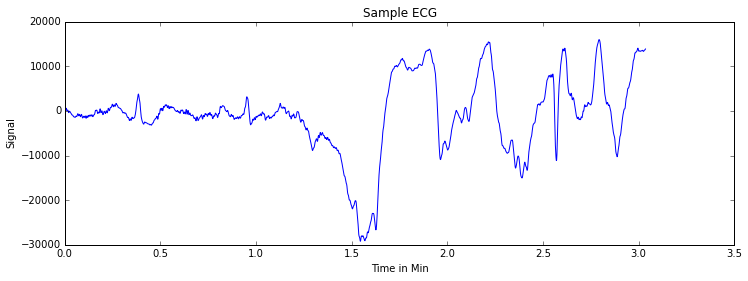

In [20]:
plt.figure(figsize=(12, 4))
plt.title("Sample ECG", fontsize=12)
plt.plot((timescale / 60.0), -measurements)
plt.xlabel('Time in Min')
plt.ylabel('Signal')
plt.show()

In [21]:
pickle.dump( allEntries, open( "ecg6.p", "wb" ) )